In [1]:
# !pip install SimPEG

In [1]:
import numpy as np
import scipy.sparse as sp
from SimPEG import Mesh, Utils, Solver
from scipy.constants import mu_0, epsilon_0
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# This will be inputs
frequency = np.logspace(-3, 2, 25)
fmax, fmin = frequency.max(), frequency.min()
max_depth_core = 5000.
rho_half = 100.

In [3]:
print ("Smallest cell size = %d m") % (500*np.sqrt(rho_half/fmax) / 4.)
print ("Padding distance = %d m") % (500*np.sqrt(rho_half/fmin) * 2)
cs = 500*np.sqrt(rho_half/fmax) / 10.
skindepth2 = 500*np.sqrt(100/fmin) * 2

npad = 1
blength = cs*1.3**(np.arange(npad)+1)
while blength < skindepth2:
    npad+=1
    blength = (cs*1.3**(np.arange(npad)+1)).sum()
print npad

ncz = int(max_depth_core / cs)
hz = [(cs, npad, -1.3), (cs, ncz)]
mesh = Mesh.TensorMesh([hz], x0='N')

print mesh.hx.sum()
print cs
print ncz

Smallest cell size = 125 m
Padding distance = 316227 m
28
340680.210724
50.0
100


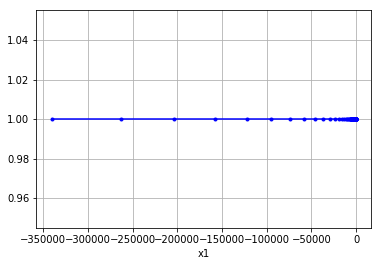

In [4]:
mesh.plotGrid()

In [5]:
mesh.vectorCCx

array([ -3.01922879e+05,  -2.33352214e+05,  -1.80605550e+05,
        -1.40031192e+05,  -1.08820148e+05,  -8.48116520e+04,
        -6.63435785e+04,  -5.21373681e+04,  -4.12095139e+04,
        -3.28034722e+04,  -2.63372863e+04,  -2.13632972e+04,
        -1.75371517e+04,  -1.45939628e+04,  -1.23299714e+04,
        -1.05884395e+04,  -9.24879965e+03,  -8.21830742e+03,
        -7.42562109e+03,  -6.81586238e+03,  -6.34681722e+03,
        -5.98601324e+03,  -5.70847172e+03,  -5.49497825e+03,
        -5.33075250e+03,  -5.20442500e+03,  -5.10725000e+03,
        -5.03250000e+03,  -4.97500000e+03,  -4.92500000e+03,
        -4.87500000e+03,  -4.82500000e+03,  -4.77500000e+03,
        -4.72500000e+03,  -4.67500000e+03,  -4.62500000e+03,
        -4.57500000e+03,  -4.52500000e+03,  -4.47500000e+03,
        -4.42500000e+03,  -4.37500000e+03,  -4.32500000e+03,
        -4.27500000e+03,  -4.22500000e+03,  -4.17500000e+03,
        -4.12500000e+03,  -4.07500000e+03,  -4.02500000e+03,
        -3.97500000e+03,

In [6]:
rho_target = 10.
depth = 2000.
depth_mid = 2500.
thickness = 1000.
tsig = thickness * 1./rho_target
thicks = (np.arange(5)+1.)*300.
sig_targets = tsig / thicks
layer_inds = np.logical_and(mesh.vectorCCx<-depth, mesh.vectorCCx>-depth-thickness)
sigma = np.ones(mesh.nC) * 1./rho_half
sigma[layer_inds] = 1./rho_target
actinds = mesh.vectorCCx > -max_depth_core

(0.005, 1.0)

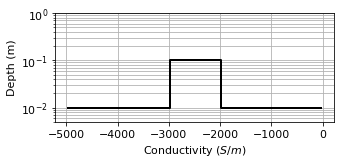

In [7]:
import matplotlib
matplotlib.rcParams["font.size"] = 11
figsize(5, 2)
sig_act = np.repeat(sigma[actinds], 2, axis=0)
z = np.repeat(mesh.vectorCCx[actinds][1:], 2, axis=0)
z = np.r_[mesh.vectorCCx[actinds][0], z, mesh.vectorCCx[actinds][-1]]
plt.plot(z, sig_act, 'k', lw=2)
plt.yscale("log")
plt.xlabel("Conductivity ($S/m$)")
plt.ylabel("Depth (m)")
plt.grid(True, which='both')
plt.ylim(5e-3, 1e0)

In [8]:
def MTsimulation(mesh, sigma, frequency):
    Zxy = []
    app_res = []
    app_phase = []
    
    for f in frequency:
        mu = np.ones(mesh.nC)*mu_0 # magnetic permeability values for all cells
        epsilon = np.ones(mesh.nC)*epsilon_0 # dielectric constant values for all cells
        omega = 2*np.pi*f # Angular frequency (rad/s)
        sigmahat = sigma # Assume sigmahat = sigma
        # In reality ...
#         sigmahat = sigma + 1j*epsilon*omega # sigmahat = sigma + 1j*omega*epsilon
        Div = mesh.faceDiv # Divergence matrix
        mesh.setCellGradBC([['dirichlet', 'dirichlet']]) # Setup boundary conditions
        Grad = mesh.cellGrad # Gradient matrix
        B = mesh.cellGradBC  # a matrix for boundary conditions
        Exbc = np.r_[0., 1.] # boundary values for Ex
        Msighat = Utils.sdiag(sigmahat) 
        Mmu = Utils.sdiag(mesh.aveCC2F * mu) 

        tempUp = sp.hstack((Grad, 1j*omega*Mmu)) # Top row of A matrix
        tempDw = sp.hstack((Msighat, Div)) # Bottom row of A matrix
        A = sp.vstack((tempUp, tempDw)) # Full A matrix
        rhs = np.r_[-B*Exbc, np.zeros(mesh.nC)] # Right-hand side   

        Ainv = Solver(A) # Factorize A matrix
        u = Ainv*rhs   # Solve A^-1 rhs = u
        Ex = u[:mesh.nC] # Extract Ex from uution vector u
        Hy = u[mesh.nC:mesh.nC+mesh.nN] # Extract Hy from solution vector u    
        P0 = sp.coo_matrix(
            (np.r_[1.], (np.r_[0], np.r_[len(u)-1])), shape=(1, len(u))
                 )
        P0 = P0.tocsr()
        Zxy_temp = - 1./(P0*u)
        Zxy.append(Zxy_temp) # Impedance
        app_res.append( abs(Zxy_temp)**2 / (mu_0*omega) )        
        app_phase.append(np.rad2deg(np.arctan(Zxy_temp.imag / Zxy_temp.real)))         
    return Zxy, app_res, app_phase

In [9]:
from em_examples import MT
n = 3
sig = np.r_[0., 1./rho_half, 1./rho_target, 1./rho_half]
mu = np.ones(n+1)
eps = np.ones(n+1)
chg = np.zeros(n+1)
tau = np.ones(n+1)
c = np.ones(n+1)
h = np.r_[1e5, depth, thickness]
app_res_ana, app_phase_ana = MT.appres(frequency,h,sig,chg,tau,c,mu,eps,n)
Zxy, app_res, app_phase = MTsimulation(mesh, sigma, frequency)

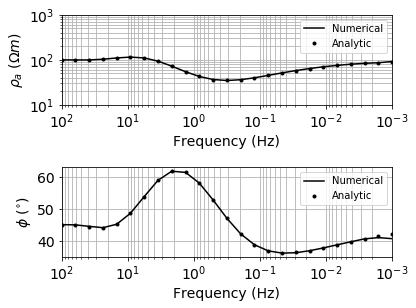

In [10]:
fig = plt.figure(figsize = (6, 4.5))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.loglog(frequency, app_res, 'k-')
ax1.loglog(frequency, app_res_ana, 'k.')
ax2.semilogx(frequency, app_phase, 'k-')
ax2.semilogx(frequency, app_phase_ana, 'k.')
ax1.set_ylim((1e1, 1e3))
for i, ax in enumerate([ax1, ax2]):
    ax.grid(True, which='both')
    ax.set_xlim(frequency.max(), frequency.min())    
    ax.set_xlabel("Frequency (Hz)")
    if i==0:
        ax.set_ylabel("$\\rho_a \ (\Omega m)$", fontsize = 14)
    else:
        ax.set_ylabel("$\phi \ (^{\circ})$", fontsize = 14)    
    ax.legend(("Numerical", "Analytic"), fontsize=10)
plt.tight_layout()

In [11]:
sigmas = []
for i in range(len(thicks)):
    layer_inds = np.logical_and(mesh.vectorCCx<-depth_mid+thicks[i]*0.5, mesh.vectorCCx>-depth_mid-thicks[i]*0.5)
    sigma_temp = np.ones(mesh.nC) * 1./rho_half
    sigma_temp[layer_inds] = sig_targets[i]
    sigmas.append(sigma_temp)

In [12]:
APP_RES = []
APP_PHASE = []
for i in range(len(thicks)):
    Zxy, app_res, app_phase = MTsimulation(mesh, sigmas[i], frequency)
    APP_RES.append(app_res)
    APP_PHASE.append(app_phase)    

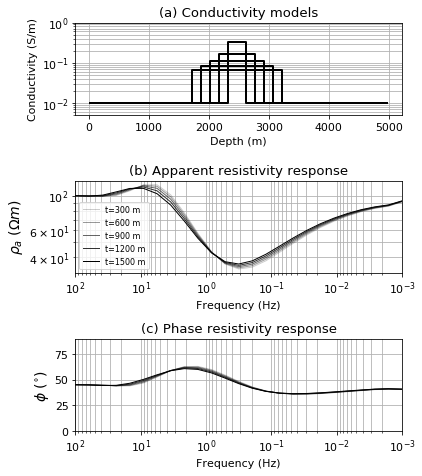

In [16]:
import matplotlib
matplotlib.rcParams["font.size"] = 11
fig = plt.figure(figsize = (6, 2.25*3))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

for i in range(len(thicks)):
    sig_act = np.repeat(sigmas[i][actinds], 2, axis=0)
    z = np.repeat(mesh.vectorCCx[actinds][1:], 2, axis=0)
    z = np.r_[mesh.vectorCCx[actinds][0], z, mesh.vectorCCx[actinds][-1]]
    ax1.semilogy(-z, sig_act, 'k', lw=2)
    ax2.loglog(frequency, APP_RES[i], 'k-', alpha=(i+1)*0.2, lw=1)
    ax3.semilogx(frequency, APP_PHASE[i], 'k-', alpha=(i+1)*0.2, lw=1)    

ax1.set_ylabel("Conductivity (S/m)")    
ax1.set_xlabel("Depth (m)")
ax1.grid(True, which='both')
ax1.set_ylim(5e-3, 1e0)

ax2.legend(([("t=%d m")%(thicks[i]) for i in range(5)]), fontsize = 8)
ax2.grid(True, which='both')
ax2.set_xlim(frequency.max(), frequency.min())
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("$\\rho_a \ (\Omega m)$", fontsize = 14)
    
ax3.grid(True, which='both')
ax3.set_xlim(frequency.max(), frequency.min())
ax3.set_ylim(0, 90.)
ax3.set_xlabel("Frequency (Hz)")
ax3.set_ylabel("$\phi \ (^{\circ})$", fontsize = 14)    
ax1.set_title("(a) Conductivity models")
ax2.set_title("(b) Apparent resistivity response")
ax3.set_title("(c) Phase resistivity response")
plt.tight_layout()
fig.savefig("Equivalent_conductance.png", dpi = 200)